Efficient Estimation of Word Representations in Vector Space
=============

Tensorflow implementation of a Continous Bag of Words Model (CBOW), as described on (https://arxiv.org/pdf/1301.3781.pdf)
------------

Train a Word2Vec CBOW model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the CBOW model.

In [5]:
data_index = 0

def generate_batch(batch_size, context_length, skip_window):
  batch_size = batch_size * context_length
  global data_index
  assert batch_size % context_length == 0
  assert context_length <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // context_length):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(context_length):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * context_length + j] = buffer[skip_window]
      labels[i * context_length + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  label_CBOW = []
  context_CBOW = []
  for i in xrange(0,len(batch), context_length):
    label_CBOW.append(batch[i])
    context_CBOW.append([l[0] for l in labels[i:i+context_length]])
  return np.array(context_CBOW), np.array(label_CBOW).reshape(batch_size / context_length, 1)

print('data:', [reverse_dictionary[di] for di in data[:8]])

for context_length, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    contexts, labels = generate_batch(batch_size=8, context_length=context_length, skip_window=skip_window)
    labels = labels[:,0]
    print('\nwith context_length = %d and skip_window = %d:' % (context_length, skip_window))
    print('    batch:')
    for con in contexts:
        print ([reverse_dictionary[word] for word in con])
    print('    labels:', [reverse_dictionary[li] for li in labels])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with context_length = 2 and skip_window = 1:
    batch:
['as', 'anarchism']
['originated', 'a']
['term', 'as']
['a', 'of']
['term', 'abuse']
['first', 'of']
['abuse', 'used']
['first', 'against']
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with context_length = 4 and skip_window = 2:
    batch:
['term', 'a', 'anarchism', 'originated']
['originated', 'as', 'of', 'term']
['of', 'a', 'as', 'abuse']
['first', 'abuse', 'a', 'term']
['used', 'first', 'of', 'term']
['abuse', 'of', 'used', 'against']
['against', 'abuse', 'early', 'first']
['early', 'working', 'first', 'used']
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


Train a CBOW model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
context_length = 4 # Total lenght of the context.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, context_length])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # sum the context_length inputs (e.g. if we used 4 words on our context, sum them)
  embed_sum = tf.reduce_sum(embed, 1)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_sum,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, context_length, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.132565
Nearest to many: addresses, milit, venue, lego, epistemic, callimico, patriot, meps,
Nearest to world: drowns, worshipping, viktor, whyte, sidewalk, ignition, unwitting, lengthwise,
Nearest to during: beatings, vocalization, arboreal, wer, luddite, therapeutic, mater, surgically,
Nearest to no: armand, phage, legalised, dynamite, trusting, fantastically, bodhidharma, worcester,
Nearest to will: splashdown, somehow, refinements, glc, mansion, terminals, recognizably, leap,
Nearest to most: relaxation, huntingdon, woody, therapists, sporting, deeper, talkative, specially,
Nearest to i: macedonians, linemen, eel, koi, barbary, oratio, maturation, shy,
Nearest to between: bassoon, netted, lack, fainter, acacia, magnon, advising, marek,
Nearest to only: x, nfl, cajun, angelo, lagged, thrax, crewe, decent,
Nearest to on: vita, meantime, afford, pale, practising, excelled, biola, indirectly,
Nearest to state: arteries, officially, huey, journ, absc

Average loss at step 52000: 3.087400
Average loss at step 54000: 3.099422
Average loss at step 56000: 2.915532
Average loss at step 58000: 3.017691
Average loss at step 60000: 3.046826
Nearest to many: some, several, various, all, numerous, certain, few, most,
Nearest to world: pbs, universe, stimulant, picts, nga, country, glace, alba,
Nearest to during: throughout, before, in, after, within, through, until, following,
Nearest to no: another, any, a, little, slashing, nothing, distributing, every,
Nearest to will: would, could, must, should, can, may, might, cannot,
Nearest to most: more, best, some, many, especially, particularly, all, less,
Nearest to i: appellations, you, ii, iii, g, tomino, henry, horrified,
Nearest to between: with, into, through, within, netted, among, sank, across,
Nearest to only: still, hayling, boar, protium, always, contests, yet, goryeo,
Nearest to on: upon, in, within, against, through, near, via, barbaric,
Nearest to state: government, capoeira, entity, 

Visualize embeddings:

In [16]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

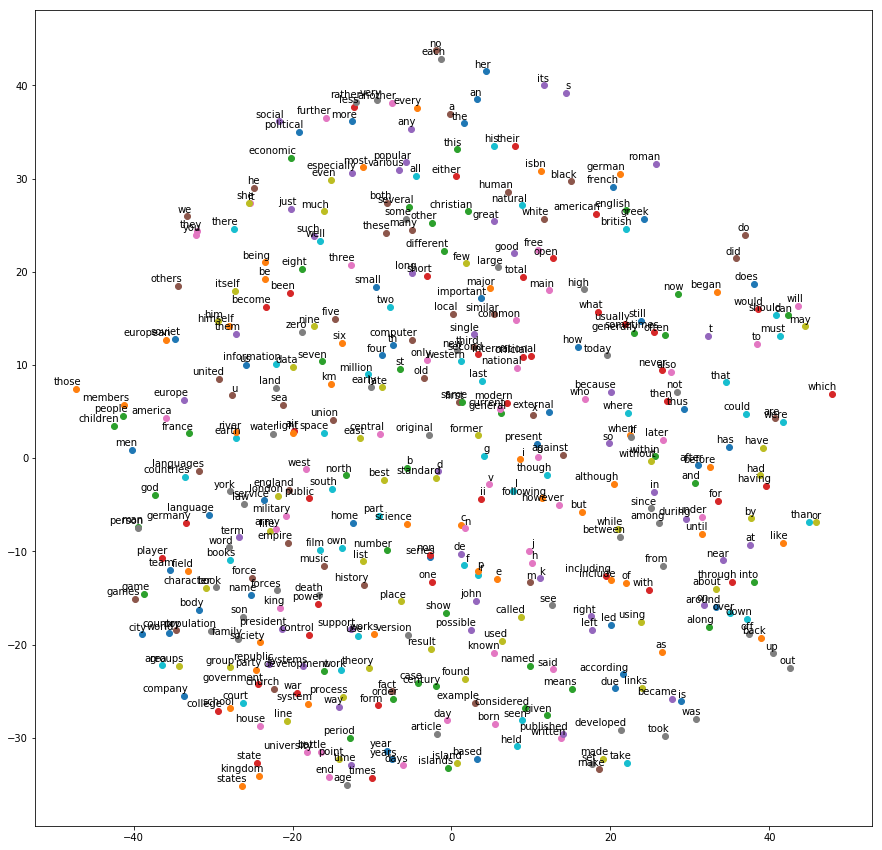

In [17]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)